In [3]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F

In [119]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=7, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 8, kernel_size=4, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(8)


        self.conv5 = nn.ConvTranspose2d(8, 6, kernel_size=4, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=7, stride=1, padding=0) 
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
        e1 = self.bn1(self.act(self.conv1(input)))
        e2 = self.bn2(self.act(self.conv2(e1)))

        e5 = self.bn5((self.conv5(e2)))
        e6 = self.conv6(e5)

        return e6


In [120]:
import sys

sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

model = Net()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.5)

num_folds = 5
fold_num = 0
train, test = get_train_test(3, num_folds=num_folds, fold_num=fold_num)

valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
print(train_aggregate.shape)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

(43, 1, 112, 24)


In [121]:
train[:, 4, :, :].reshape(train.shape[0], 1, train.shape[2], -1).shape

(43, 1, 112, 24)

In [122]:
def reg_loss(pred, out):
    l1_loss = torch.sum(torch.abs(pred-out))  
    reg = 0.5*torch.sum(torch.abs(out))
    return l1_loss + reg

In [125]:
model = Net()

loss_fn = nn.L1Loss()
# loss_fun = reg_loss
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.5)

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True
if cuda_av:
    model = model.cuda()
    loss_fn = loss_fn.cuda()
app_idx = APPLIANCE_ORDER.index('hvac')   
    
inp = Variable(torch.Tensor(train_aggregate))
out = Variable(torch.Tensor(train[:, app_idx, :, :].reshape(train.shape[0], 1, train.shape[2], -1)))
test_inp = Variable(torch.Tensor(test_aggregate))
test_out = Variable(torch.Tensor(test[:, app_idx, :, :].reshape(test.shape[0], 1, test.shape[2], -1)))
if cuda_av:
    inp = inp.cuda()
    out = out.cuda()
    test_inp = test_inp.cuda()
    test_out = test_out.cuda()

In [126]:

for epoch in range(5000):
    
    pred = model(inp)
#     print(pred.shape)
#     pred = torch.clamp(pred, min=0.)
    loss = loss_fn(pred, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch %100 == 0:
        
        
        test_pr = model(test_inp)
        test_pr = torch.clamp(test_pr, min=0.)
        test_loss = loss_fn(test_pr, test_out)
        
        print(epoch, "Training Error:", loss.data[0], "Test Error:", test_loss.data[0])
#         print(test_pr.max())

0 Training Error: 918.140625 Test Error: 785.6419677734375
100 Training Error: 917.9884643554688 Test Error: 785.5331420898438
200 Training Error: 917.7731323242188 Test Error: 785.3159790039062
300 Training Error: 917.2589111328125 Test Error: 784.7881469726562
400 Training Error: 915.2056884765625 Test Error: 782.7329711914062
500 Training Error: 906.6270141601562 Test Error: 773.994384765625
600 Training Error: 873.5189819335938 Test Error: 739.728271484375
700 Training Error: 756.0985107421875 Test Error: 618.2615356445312
800 Training Error: 538.8740844726562 Test Error: 420.1239318847656
900 Training Error: 453.9221496582031 Test Error: 374.09783935546875
1000 Training Error: 422.3301086425781 Test Error: 359.3106384277344
1100 Training Error: 413.9225158691406 Test Error: 358.55426025390625
1200 Training Error: 433.28619384765625 Test Error: 360.2086486816406
1300 Training Error: 392.9485778808594 Test Error: 347.1717529296875
1400 Training Error: 400.9958190917969 Test Error: 3

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [20]:
test_pr = torch.clamp(test_pr, min=0.)
pred = torch.clamp(pred, min=0.)

14


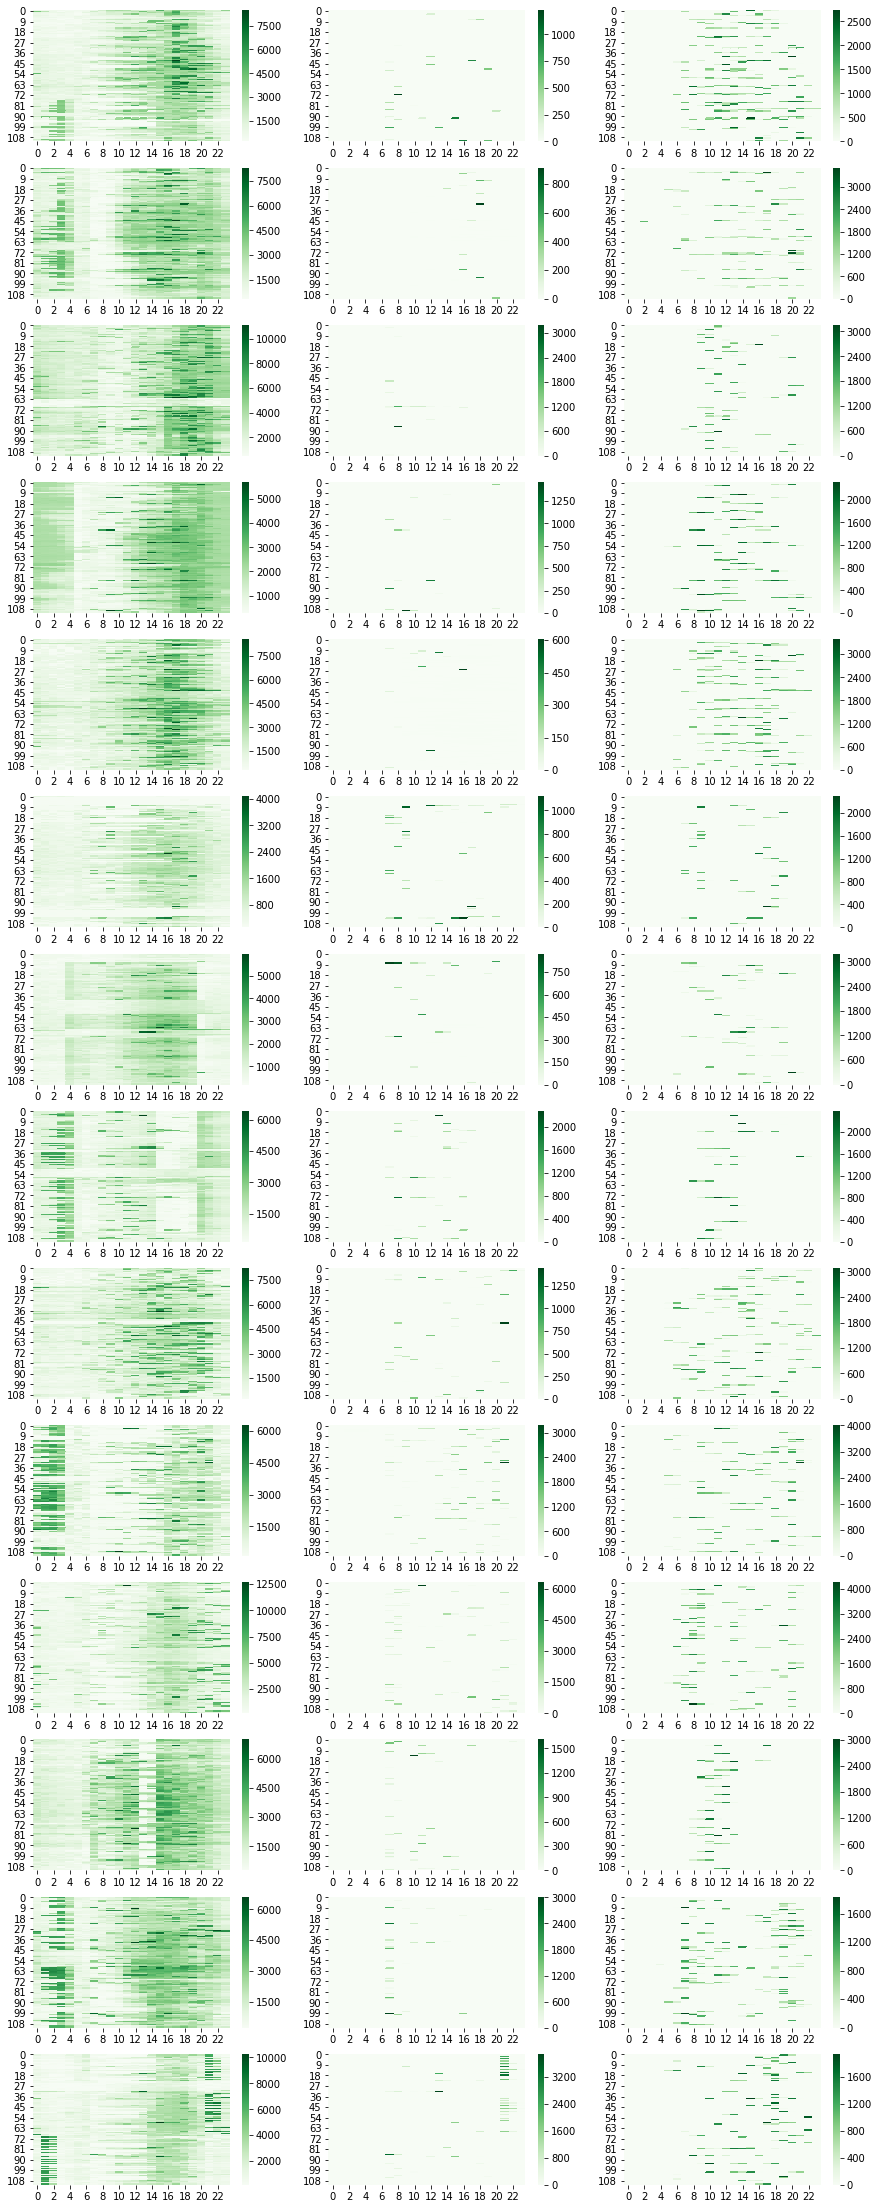

In [21]:
num_test = test_pr.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=num_test,ncols=3, figsize=(15, 40))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)


for i in range(num_test):
    sns.heatmap(pd.DataFrame(test_inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0])
    sns.heatmap(pd.DataFrame(test_pr.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




In [ ]:
num_train = pred.cpu().data.numpy().shape[0]
num_test = pred.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=9,ncols=3, figsize=(15, 20))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)



for i in range(num_train):
    sns.heatmap(pd.DataFrame(inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0], vmin=0, vmax=10000)
    sns.heatmap(pd.DataFrame(pred.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




43


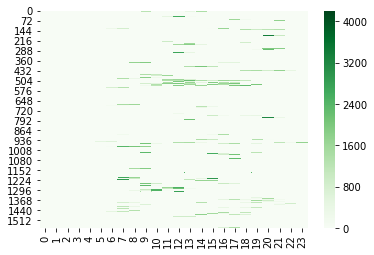

In [388]:
sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy().reshape(-1, 24)), cmap='Greens')